## Imports

In [1]:
import pandas as pd 
import numpy as np
import pybedtools
import pickle
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
from statistics import mean
from collections import Counter

import sklearn
from sklearn.calibration import *
from sklearn.preprocessing import *
from sklearn.feature_selection import *
from sklearn.model_selection import *
from sklearn.svm import *
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import *
from scipy import interp
from sksurv.nonparametric import kaplan_meier_estimator
from sksurv.preprocessing import OneHotEncoder
from sksurv.linear_model import CoxPHSurvivalAnalysis
from sksurv.metrics import concordance_index_censored
from lifelines.statistics import logrank_test
from lifelines import CoxPHFitter
from lifelines.utils import concordance_index

## Load METABRIC clinical file

In [2]:
metabric_clinical = pd.read_csv('clinical_METABRIC.tsv', sep='\t')
print("Original Shape: ", metabric_clinical.shape)
metabric_clinical = metabric_clinical.loc[(metabric_clinical['ER.Expr'] == '+') & (metabric_clinical['Her2.Expr'] == '-')]
print("Only ER+/HER2-: ", metabric_clinical.shape)
metabric_clinical = metabric_clinical[metabric_clinical.iC10.apply(lambda x: x in ['3','4ER+','7','8','1','2','6','9'])]
metabric_clinical = metabric_clinical.loc[metabric_clinical['Size'] == metabric_clinical['Size']]
metabric_clinical = metabric_clinical.loc[metabric_clinical['Grade'] == metabric_clinical['Grade']]
label = []
for index,row in metabric_clinical.iterrows():
    if row['iC10'] in ['3','4ER+','7','8']:
        label.append(0)
    elif row['iC10'] in ['1','2','6','9']:
        label.append(1)
metabric_clinical['label'] = label
#metabric_clinical = metabric_clinical.loc[(metabric_clinical['T'] > 1825) & (metabric_clinical['TDR'] > 1825)]
metabric_clinical['DeathBreast'] = metabric_clinical['DeathBreast'].astype('bool')
metabric_clinical['Lymph.Nodes.Positive'] = metabric_clinical['Lymph.Nodes.Positive'].astype('float')
metabric_clinical['LR'] = metabric_clinical['LR'].astype('bool')
metabric_clinical['DR'] = metabric_clinical['DR'].astype('bool')
metabric_clinical['TLDR'] = metabric_clinical[['TLR','TDR']].min(axis=1)
metabric_clinical['LDR'] = (metabric_clinical['LR'] | metabric_clinical['DR']).astype('bool')
metabric_clinical['TDLR'] = metabric_clinical[['T','TLR']].min(axis=1)
metabric_clinical['DLR'] = (metabric_clinical['DeathBreast'] | metabric_clinical['LR']).astype('bool')
metabric_clinical['TDDR'] = metabric_clinical[['T','TDR']].min(axis=1)
metabric_clinical['DDR'] = (metabric_clinical['DeathBreast'] | metabric_clinical['DR']).astype('bool')
metabric_clinical['TDLDR'] = metabric_clinical[['T','TLR','TDR']].min(axis=1)
metabric_clinical['DLDR'] = (metabric_clinical['DeathBreast'] | metabric_clinical['DR'] | metabric_clinical['LR']).astype('bool')

metabric_clinical.drop_duplicates(inplace=True)

print("Only ER+/HER2- in 8 IntClusts: ", metabric_clinical.shape)
display(metabric_clinical.head())

Original Shape:  (1980, 35)
Only ER+/HER2-:  (1398, 35)
Only ER+/HER2- in 8 IntClusts:  (1285, 44)


,METABRIC.ID,MATCHED.NORMAL.METABRIC.ID,Cohort,Age.At.Diagnosis,Breast.Tumour.Laterality,Date.Of.Diagnosis,Last.Followup.Status,NPI,ER.Status,Inferred.Menopausal.State,...,Complete.Rec.History,label,TLDR,LDR,TDLR,DLR,TDDR,DDR,TDLDR,DLDR
0,MB-0002,MB-0003,1,43.19,r,2000/12,a,4.020,pos,pre,...,YES,0,2539,False,2539,False,2539,False,2539,False
1,MB-0005,MB-0004,1,48.87,r,2001/02,d-d.s.,4.030,pos,pre,...,YES,0,4599,True,4911,True,4599,True,4599,True
2,MB-0006,MB-0007,1,47.68,r,2001/02,a,4.050,pos,pre,...,YES,1,4948,False,4948,False,4948,False,4948,False
3,MB-0010,MB-0011,1,78.77,l,2001/03,d-d.s.,4.062,pos,post,...,YES,0,88,True,234,True,88,True,88,True
4,MB-0014,MB-0015,1,56.45,r,2001/04,a,4.020,pos,post,...,YES,0,4930,False,4930,False,4930,False,4930,False


## Load CNA data

### Load segmented CNA file

In [3]:
metabric_iclust = pd.read_csv('CNA_0.005eps_metabric.tsv', sep='\t')
metabric_iclust.rename(columns={metabric_iclust.columns[0]: 'sample'}, inplace=True)
display(metabric_iclust.head())
display(metabric_iclust.shape)

,sample,chr1.51599-72034,chr1.72034-75800,chr1.75800-88452,chr1.88452-88466,chr1.88466-218570,chr1.218570-218593,chr1.218593-218939,chr1.218939-219037,chr1.219037-219483,...,chr22.41285376-41285697,chr22.41285697-43029372,chr22.43029372-43032379,chr22.43032379-45779329,chr22.45779329-45780363,chr22.45780363-45780734,chr22.45780734-47538878,chr22.47538878-49319975,chr22.49319975-49320621,chr22.49320621-49581322
0,MB-0000,-0.112070,0.571503,0.571503,0.571503,0.571503,0.571503,0.571503,0.571503,0.571503,...,-0.050073,-0.050073,-0.050073,-0.050073,-0.050073,-0.050073,-0.050073,-0.050073,-0.050073,-0.050073
1,MB-0002,0.002596,0.002596,0.002596,0.002596,0.002596,0.002596,0.002596,0.002596,0.002596,...,-0.265810,-0.265810,-0.265810,-0.265810,-0.265810,-0.265810,-0.265810,-0.265810,-0.265810,-0.265810
2,MB-0005,0.220760,0.220760,0.220760,0.220760,0.220760,0.220760,0.220760,0.220760,0.220760,...,-0.041826,-0.041826,-0.041826,-0.041826,-0.041826,-0.041826,-0.041826,-0.041826,-0.041826,-0.041826
3,MB-0006,-0.071814,-0.071814,-0.071814,-0.071814,-0.071814,-0.071814,-0.071814,-0.071814,-0.071814,...,-0.310061,-0.310061,-0.310061,-0.310061,-0.310061,-0.310061,-0.310061,-0.310061,-0.310061,-0.310061
4,MB-0008,0.178845,0.178845,0.178845,0.178845,0.178845,0.178845,0.178845,0.178845,0.178845,...,-0.361051,-0.274476,-0.122731,-0.274476,-0.274476,-0.274476,-0.274476,-0.274476,-0.055292,-0.055292


(1360, 4795)

### Merge CNA and clinical tables

In [4]:
metabric_iclust_joined = metabric_iclust.merge(metabric_clinical, how='inner', left_on='sample', right_on='METABRIC.ID')#right_on="ID")
metabric_iclust_joined = metabric_iclust_joined.drop('METABRIC.ID', axis=1)
display(metabric_iclust_joined.head())
display(metabric_iclust_joined.shape)

,sample,chr1.51599-72034,chr1.72034-75800,chr1.75800-88452,chr1.88452-88466,chr1.88466-218570,chr1.218570-218593,chr1.218593-218939,chr1.218939-219037,chr1.219037-219483,...,Complete.Rec.History,label,TLDR,LDR,TDLR,DLR,TDDR,DDR,TDLDR,DLDR
0,MB-0000,-0.112070,0.571503,0.571503,0.571503,0.571503,0.571503,0.571503,0.571503,0.571503,...,YES,0,4215,False,4215,False,4215,False,4215,False
1,MB-0002,0.002596,0.002596,0.002596,0.002596,0.002596,0.002596,0.002596,0.002596,0.002596,...,YES,0,2539,False,2539,False,2539,False,2539,False
2,MB-0005,0.220760,0.220760,0.220760,0.220760,0.220760,0.220760,0.220760,0.220760,0.220760,...,YES,0,4599,True,4911,True,4599,True,4599,True
3,MB-0006,-0.071814,-0.071814,-0.071814,-0.071814,-0.071814,-0.071814,-0.071814,-0.071814,-0.071814,...,YES,1,4948,False,4948,False,4948,False,4948,False
4,MB-0008,0.178845,0.178845,0.178845,0.178845,0.178845,0.178845,0.178845,0.178845,0.178845,...,YES,1,564,True,564,True,941,True,564,True


(1285, 4838)

## Prepare for Model Training

### Extract Features

In [5]:
pd.set_option('display.max_columns', 40)
metabric_iclust_joined = metabric_iclust_joined.loc[metabric_iclust_joined['Size'] == metabric_iclust_joined['Size']]
metabric_iclust_joined = metabric_iclust_joined.loc[metabric_iclust_joined['Grade'] == metabric_iclust_joined['Grade']]
X = metabric_iclust_joined.drop('label', axis=1)
X = X.drop('sample', axis=1)
X = X.iloc[:,:4794]
X['Age.At.Diagnosis'] = metabric_iclust_joined['Age.At.Diagnosis']
X['Size'] = metabric_iclust_joined['Size']
X['Grade'] = metabric_iclust_joined['Grade']
X['Lymph.Nodes.Positive']  = metabric_iclust_joined['Lymph.Nodes.Positive']
display(X.shape)
display(X.head())

(1285, 4798)

,chr1.51599-72034,chr1.72034-75800,chr1.75800-88452,chr1.88452-88466,chr1.88466-218570,chr1.218570-218593,chr1.218593-218939,chr1.218939-219037,chr1.219037-219483,chr1.219483-219541,chr1.219541-225534,chr1.225534-225802,chr1.225802-346307,chr1.346307-394035,chr1.394035-524415,chr1.524415-593454,chr1.593454-1617779,chr1.1617779-1618687,chr1.1618687-1631964,chr1.1631964-1677448,...,chr22.37733740-38924519,chr22.38924519-38930433,chr22.38930433-41227227,chr22.41227227-41229385,chr22.41229385-41272907,chr22.41272907-41285376,chr22.41285376-41285697,chr22.41285697-43029372,chr22.43029372-43032379,chr22.43032379-45779329,chr22.45779329-45780363,chr22.45780363-45780734,chr22.45780734-47538878,chr22.47538878-49319975,chr22.49319975-49320621,chr22.49320621-49581322,Age.At.Diagnosis,Size,Grade,Lymph.Nodes.Positive
0,-0.112070,0.571503,0.571503,0.571503,0.571503,0.571503,0.571503,0.571503,0.571503,0.571503,0.571503,0.571503,0.571503,0.004068,0.004068,0.004068,-0.050073,-0.050073,-0.050073,-0.050073,...,-0.112070,-0.112070,-0.112070,-0.050073,-0.050073,-0.050073,-0.050073,-0.050073,-0.050073,-0.050073,-0.050073,-0.050073,-0.050073,-0.050073,-0.050073,-0.050073,75.65,22.0,3.0,10.0
1,0.002596,0.002596,0.002596,0.002596,0.002596,0.002596,0.002596,0.002596,0.002596,0.002596,0.002596,0.002596,0.002596,0.002596,0.002596,0.002596,0.002596,0.002596,0.002596,0.002596,...,-0.265810,-0.265810,-0.265810,-0.265810,-0.265810,-0.265810,-0.265810,-0.265810,-0.265810,-0.265810,-0.265810,-0.265810,-0.265810,-0.265810,-0.265810,-0.265810,43.19,10.0,3.0,0.0
2,0.220760,0.220760,0.220760,0.220760,0.220760,0.220760,0.220760,0.220760,0.220760,0.220760,0.220760,0.220760,0.220760,0.220760,0.220760,0.220760,-0.041826,-0.041826,-0.041826,-0.041826,...,-0.041826,-0.041826,-0.041826,-0.041826,-0.041826,-0.041826,-0.041826,-0.041826,-0.041826,-0.041826,-0.041826,-0.041826,-0.041826,-0.041826,-0.041826,-0.041826,48.87,15.0,2.0,1.0
3,-0.071814,-0.071814,-0.071814,-0.071814,-0.071814,-0.071814,-0.071814,-0.071814,-0.071814,-0.071814,-0.071814,-0.071814,-0.071814,-0.071814,-0.071814,-0.071814,-0.071814,-0.071814,-0.071814,-0.071814,...,-0.310061,-0.310061,-0.310061,-0.310061,-0.310061,-0.310061,-0.310061,-0.310061,-0.310061,-0.310061,-0.310061,-0.310061,-0.310061,-0.310061,-0.310061,-0.310061,47.68,25.0,2.0,3.0
4,0.178845,0.178845,0.178845,0.178845,0.178845,0.178845,0.178845,0.178845,0.178845,0.178845,0.178845,0.178845,0.178845,0.178845,0.178845,0.178845,-0.274476,-0.437599,-0.437599,-0.437599,...,-0.274476,-0.437599,-0.437599,-0.361051,-0.361051,-0.361051,-0.361051,-0.274476,-0.122731,-0.274476,-0.274476,-0.274476,-0.274476,-0.274476,-0.055292,-0.055292,76.97,40.0,3.0,8.0


### Extract Targets

In [6]:
Y = metabric_iclust_joined.iloc[:,4795:]
# Y['DR'] = Y['DR'].astype(int)
# Y['DDR'] = Y['DDR'].astype(int)
display(Y.head())
display(Y.shape)

,MATCHED.NORMAL.METABRIC.ID,Cohort,Age.At.Diagnosis,Breast.Tumour.Laterality,Date.Of.Diagnosis,Last.Followup.Status,NPI,ER.Status,Inferred.Menopausal.State,Lymph.Nodes.Positive,Breast.Surgery,CT,HT,RT,Grade,Size,Histological.Type,Stage,Cellularity,DeathBreast,...,LR,TDR,DR,HER2.SNP6,iC10,Pam50Subtype,ER.Expr,Her2.Expr,PR.Expr,ClaudinSubtype,Complete.Rec.History,label,TLDR,LDR,TDLR,DLR,TDDR,DDR,TDLDR,DLDR
0,NaN,1,75.65,r,2000/12,a,6.044,pos,post,10.0,MASTECTOMY,NO/NA,TAM/AI,CW,3.0,22.0,IDC,2.0,NaN,False,...,False,4215,False,NEUT,4ER+,Normal,+,-,-,claudin-low,YES,0,4215,False,4215,False,4215,False,4215,False
1,MB-0003,1,43.19,r,2000/12,a,4.020,pos,pre,0.0,BREAST CONSERVING,NO/NA,TAM,CW,3.0,10.0,IDC,1.0,high,False,...,False,2539,False,NEUT,4ER+,LumA,+,-,+,LumA,YES,0,2539,False,2539,False,2539,False,2539,False
2,MB-0004,1,48.87,r,2001/02,d-d.s.,4.030,pos,pre,1.0,MASTECTOMY,OTHER,TAM,NO/NA,2.0,15.0,IDC,2.0,high,True,...,False,4599,True,NEUT,3,LumB,+,-,+,LumB,YES,0,4599,True,4911,True,4599,True,4599,True
3,MB-0007,1,47.68,r,2001/02,a,4.050,pos,pre,3.0,MASTECTOMY,OTHER,AI,CW,2.0,25.0,IDC,2.0,moderate,False,...,False,4948,False,NEUT,9,LumB,+,-,+,LumB,YES,1,4948,False,4948,False,4948,False,4948,False
4,NaN,1,76.97,r,2001/03,d-d.s.,6.080,pos,post,8.0,MASTECTOMY,CAPE,TAM,CW-NODAL,3.0,40.0,IDC,2.0,high,True,...,True,941,True,NEUT,9,LumB,+,-,+,LumB,YES,1,564,True,564,True,941,True,564,True


(1285, 43)

## SVM with Gaussian Kernel

### Select Gamma and C

In [7]:
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=0)
tuned_parameters = [{'gamma': [0.01, 0.001, 0.0001],'C': [0.1, 1, 10]}]

best_params = []

for train_index, test_index in cv.split(X, Y['label']):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    Y_train, Y_test = Y.iloc[train_index], Y.iloc[test_index]
    scaler = StandardScaler().fit(X_train)
    X_train = scaler.transform(X_train)
    X_test = scaler.transform(X_test)
    selector = SelectKBest(f_classif, k=500).fit(X_train, Y_train['label'])
    X_train = selector.transform(X_train)
    X_test = selector.transform(X_test)
    pos = Y_train['label'] == 1
    neg = Y_train['label'] == 0
    pos_ratio = 1 / (len(Y_train['label'][pos]) / len(Y_train['label']))
    clf = GridSearchCV(SVC(kernel='rbf', probability=True, class_weight={1:pos_ratio}), tuned_parameters, cv=cv, scoring='average_precision')
    clf.fit(X_train, Y_train['label'])
    print(clf.best_params_)
    best_params.append((clf.best_params_['C'], clf.best_params_['gamma']))
    
modes = Counter(best_params).most_common(1)

best_c = modes[0][0][0]
best_gamma = modes[0][0][1]

print()
print("Best C: ", best_c)
print("Best Gamma: ", best_gamma)

{'C': 10, 'gamma': 0.0001}
{'C': 1, 'gamma': 0.001}
{'C': 1, 'gamma': 0.001}
{'C': 1, 'gamma': 0.001}
{'C': 1, 'gamma': 0.001}

Best C:  1
Best Gamma:  0.001


### AUROC

Fold: 	 1
Fold: 	 2
Fold: 	 3
Fold: 	 4
Fold: 	 5


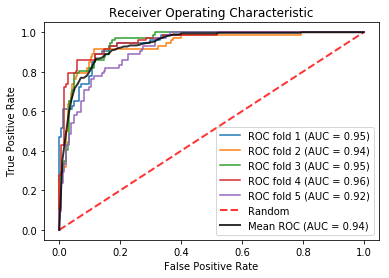

In [8]:
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=0)

tprs = []
aucs = []
mean_fpr = np.linspace(0, 1, 100)

i = 0
for train_index, test_index in cv.split(X, Y['label']):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    Y_train, Y_test = Y.iloc[train_index], Y.iloc[test_index]
    scaler = StandardScaler().fit(X_train)
    X_train = scaler.transform(X_train)
    X_test = scaler.transform(X_test)
    selector = SelectKBest(f_classif, k=500).fit(X_train, Y_train['label'])
    X_train = selector.transform(X_train)
    X_test = selector.transform(X_test)
    pos = Y_train['label'] == 1
    neg = Y_train['label'] == 0
    pos_ratio = 1 / (len(Y_train['label'][pos]) / len(Y_train['label']))
    clf = SVC(kernel='rbf', gamma = best_gamma, C = best_c, probability=True, class_weight={1:pos_ratio})
    clf.fit(X_train, Y_train['label'])
    probas_ = clf.predict_proba(X_test)
    fpr, tpr, thresholds = roc_curve(Y_test['label'], probas_[:, 1])
    tprs.append(interp(mean_fpr, fpr, tpr))
    tprs[-1][0] = 0.0
    roc_auc = auc(fpr, tpr)
    aucs.append(roc_auc)
    plt.plot(fpr, tpr,
             label='ROC fold %d (AUC = %0.2f)' % (i+1, roc_auc))
    i += 1
    print("Fold: \t", i)
    
plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',
         label='Random', alpha=.8)

mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
std_auc = np.std(aucs)
plt.plot(mean_fpr, mean_tpr, color='black',
         label=r'Mean ROC (AUC = %0.2f)' % (mean_auc),
         lw=2, alpha=.8)

plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

### AUPRC

Fold: 	 1
Fold: 	 2
Fold: 	 3
Fold: 	 4
Fold: 	 5


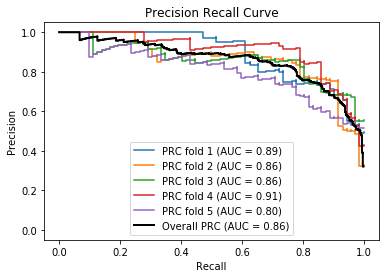

In [9]:
y_real = []
y_proba = []
auprcs = []

i = 0
for train_index, test_index in cv.split(X, Y['label']):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    Y_train, Y_test = Y.iloc[train_index], Y.iloc[test_index]
    scaler = StandardScaler().fit(X_train)
    X_train = scaler.transform(X_train)
    X_test = scaler.transform(X_test)
    selector = SelectKBest(f_classif, k=500).fit(X_train, Y_train['label'])
    X_train = selector.transform(X_train)
    X_test = selector.transform(X_test)
    pos = Y_train['label'] == 1
    neg = Y_train['label'] == 0
    pos_ratio = 1 / (len(Y_train['label'][pos]) / len(Y_train['label']))
    clf = SVC(kernel='rbf', gamma = best_gamma, C = best_c, probability=True, class_weight={1:pos_ratio})
    clf.fit(X_train, Y_train['label'])
    probas_ = clf.predict_proba(X_test)
    precision, recall, _ = precision_recall_curve(Y_test['label'], probas_[:,1])
    auprc = auc(recall, precision)
    lab = 'PRC fold %d (AUC = %0.2f)' % (i+1, auprc)
    plt.step(recall, precision, label=lab)
    y_real.append(Y_test['label'])
    y_proba.append(probas_[:,1])
    auprcs.append(auprc)
    i += 1
    print("Fold: \t", i)
    
y_real = np.concatenate(y_real)
y_proba = np.concatenate(y_proba)
precision, recall, _ = precision_recall_curve(y_real, y_proba)
lab = 'Overall PRC (AUC = %0.2f)' % (auc(recall, precision))
plt.step(recall, precision, label=lab, lw=2, color='black')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend(loc='lower center')
plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.title('Precision Recall Curve')
plt.show()

### Predict

In [10]:
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=0)

preds = np.zeros(Y['label'].shape[0])
preds_bin = np.zeros(Y['label'].shape[0])

auroc = []
auprc = []
nll = []
f1 = []
precision = []
recall = []

f = 0
for train_index, test_index in cv.split(X, Y['label']):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    Y_train, Y_test = Y.iloc[train_index], Y.iloc[test_index]
    scaler = StandardScaler().fit(X_train)
    X_train = scaler.transform(X_train)
    X_test = scaler.transform(X_test)
    selector = SelectKBest(f_classif, k=500).fit(X_train, Y_train['label'])
    X_train = selector.transform(X_train)
    X_test = selector.transform(X_test)
    pos = Y_train['label'] == 1
    neg = Y_train['label'] == 0
    pos_ratio = 1 / (len(Y_train['label'][pos]) / len(Y_train['label']))
    clf = SVC(kernel='rbf', gamma = best_gamma, C = best_c, probability=True, class_weight={1:pos_ratio})
    clf.fit(X_train, Y_train['label'])
    fold_preds = clf.predict_proba(X_test)[:,1]

    auroc.append(roc_auc_score(Y_test['label'], fold_preds))
    auprc.append(average_precision_score(Y_test['label'], fold_preds))
    nll.append(log_loss(Y_test['label'], fold_preds))
    
    fold_preds_bin = clf.predict(X_test)
    
    f1.append(f1_score(Y_test['label'], fold_preds_bin))
    precision.append(precision_score(Y_test['label'], fold_preds_bin))
    recall.append(recall_score(Y_test['label'], fold_preds_bin))
    
    for i,j in zip(test_index,range(len(fold_preds))):
        preds[i] = fold_preds[j]
        preds_bin[i] = fold_preds_bin[j]

    f += 1
    print("Fold: \t", f)

print()
#print('AUROC: \t\t', round(mean(auroc),4))
#print('AUPRC: \t\t', round(mean(auprc),4))
#print('NLL: \t\t', round(mean(nll), 4))
print('F1: \t\t', round(mean(f1), 4))
print('Precision: \t', round(mean(precision), 4))
print('Recall: \t', round(mean(recall), 4))

Fold: 	 1
Fold: 	 2
Fold: 	 3
Fold: 	 4
Fold: 	 5

AUROC: 		 0.9414
AUPRC: 		 0.8656
NLL: 		 0.2784
F1: 		 0.7865
Precision: 	 0.723
Recall: 	 0.8639


## Evaluate

### Normalized Confusion Matrix

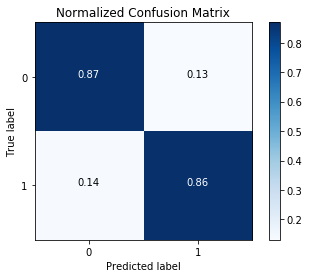

In [11]:
import itertools

cm = confusion_matrix(Y['label'],preds_bin)
cm = cm.astype('float') / cm.sum(axis = 1)[:, np.newaxis]

plt.imshow(cm, cmap=plt.cm.Blues)
plt.title('Normalized Confusion Matrix')
plt.colorbar()
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.xticks([0, 1]); plt.yticks([0, 1])
plt.grid(False)
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, format(cm[i, j], '.2f'),
             horizontalalignment='center',
             color='white' if cm[i, j] > 0.5 else 'black')

### Raw Confusion Matrix

Confusion matrix:
 [[804 121]
 [ 49 311]]


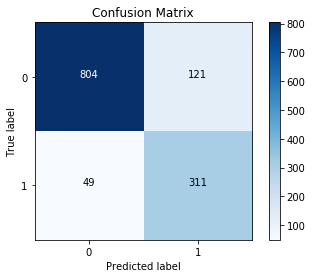

In [12]:
cm = confusion_matrix(Y['label'],preds_bin)
print('Confusion matrix:\n',cm)

plt.imshow(cm, cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.xticks([0, 1]); plt.yticks([0, 1])
plt.grid(False)
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, format(cm[i, j]),
             horizontalalignment='center',
             color='white' if cm[i, j] > 500 else 'black')

## Survival Analysis on Predictions

### Distant Relapse (DR)

<lifelines.StatisticalResult>
               t_0 = -1
 null_distribution = chi squared
degrees_of_freedom = 1

---
test_statistic      p  -log2(p)
         47.18 <0.005     37.17


None

Iteration 7: norm_delta = 0.00000, step_size = 1.0000, ll = -2324.42723, newton_decrement = 0.00000, seconds_since_start = 0.2Convergence completed after 7 iterations.
<lifelines.CoxPHFitter: fitted with 1285 observations, 931 censored>
      duration col = 'TDR'
         event col = 'DR'
number of subjects = 1285
  number of events = 354
partial log-likelihood = -2324.43
  time fit was run = 2019-06-12 02:09:56 UTC

---
                      coef exp(coef)  se(coef)    z      p  -log2(p)  lower 0.95  upper 0.95
preds_bin             0.55      1.73      0.12 4.73 <0.005     18.76        0.32        0.77
Age.At.Diagnosis      0.00      1.00      0.00 0.36   0.72      0.47       -0.01        0.01
Size                  0.02      1.02      0.00 7.19 <0.005     40.45        0.01        0.02
Lymph.Nodes.Positive  0.06      1.06      0.01 7.15 <0.005     40.05        0.04        0.07
Grade                 0.14      1.15      0.09 1.52   0.13      2.96       -0.04        0.32
---
Concordance =

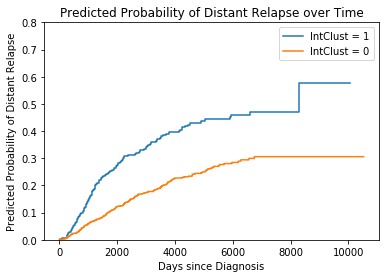

In [13]:
risk_ = [[],[]]
time_ = [[],[]]

for risk_type in (1, 0):
    mask_risk = preds_bin == risk_type
    time, survival_prob = kaplan_meier_estimator(
        Y['DR'][mask_risk],
        Y['TDR'][mask_risk])
    risk_[risk_type] = Y['DR'][mask_risk]
    time_[risk_type] = Y['TDR'][mask_risk]
    
    plt.step(time, 1 - survival_prob, where="post",
             label="IntClust = %s" % risk_type)

plt.ylabel("Predicted Probability of Distant Relapse")
plt.xlabel("Days since Diagnosis")
plt.title("Predicted Probability of Distant Relapse over Time")
plt.ylim([0.00, 0.8])
plt.legend(loc="best")

results = logrank_test(time_[0], time_[1], risk_[0], risk_[1])
display(results.print_summary())

cph = CoxPHFitter()
Y['preds'] = preds
Y['preds_bin'] = preds_bin
cph.fit(Y[['preds_bin','Age.At.Diagnosis','Size','Lymph.Nodes.Positive','Grade','DR','TDR']], duration_col='TDR', event_col='DR', show_progress=True)
cph.print_summary()

### Local Relapse (LR)

<lifelines.StatisticalResult>
               t_0 = -1
 null_distribution = chi squared
degrees_of_freedom = 1

---
test_statistic    p  -log2(p)
          3.45 0.06      3.98


None

Iteration 7: norm_delta = 0.00000, step_size = 1.0000, ll = -1121.37238, newton_decrement = 0.00000, seconds_since_start = 0.1Convergence completed after 7 iterations.
<lifelines.CoxPHFitter: fitted with 1285 observations, 1115 censored>
      duration col = 'TLR'
         event col = 'LR'
number of subjects = 1285
  number of events = 170
partial log-likelihood = -1121.37
  time fit was run = 2019-06-12 02:09:57 UTC

---
                      coef exp(coef)  se(coef)     z      p  -log2(p)  lower 0.95  upper 0.95
preds_bin             0.18      1.20      0.17  1.06   0.29      1.80       -0.15        0.52
Age.At.Diagnosis     -0.03      0.97      0.01 -3.97 <0.005     13.77       -0.04       -0.01
Size                  0.01      1.01      0.00  1.27   0.20      2.29       -0.00        0.02
Lymph.Nodes.Positive  0.06      1.06      0.01  4.24 <0.005     15.43        0.03        0.08
Grade                 0.17      1.18      0.13  1.27   0.20      2.29       -0.09        0.42
---
Concor

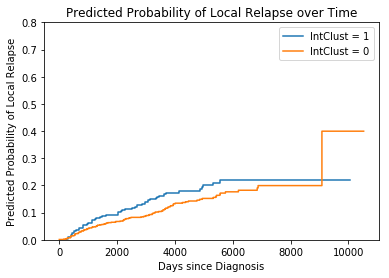

In [14]:
risk_ = [[],[]]
time_ = [[],[]]

for risk_type in (1, 0):
    mask_risk = preds_bin == risk_type
    time, survival_prob = kaplan_meier_estimator(
        Y['LR'][mask_risk],
        Y['TLR'][mask_risk])
    risk_[risk_type] = Y['LR'][mask_risk]
    time_[risk_type] = Y['TLR'][mask_risk]
    
    plt.step(time, 1 - survival_prob, where="post",
             label="IntClust = %s" % risk_type)

plt.ylabel("Predicted Probability of Local Relapse")
plt.xlabel("Days since Diagnosis")
plt.title("Predicted Probability of Local Relapse over Time")
plt.ylim([0.00, 0.8])
plt.legend(loc="best")

results = logrank_test(time_[0], time_[1], risk_[0], risk_[1])
display(results.print_summary())

cph = CoxPHFitter()
Y['preds'] = preds
Y['preds_bin'] = preds_bin
cph.fit(Y[['preds_bin','Age.At.Diagnosis','Size','Lymph.Nodes.Positive','Grade','LR','TLR']], duration_col='TLR', event_col='LR', show_progress=True)
cph.print_summary()

### Disease Specific Death (DSD)

<lifelines.StatisticalResult>
               t_0 = -1
 null_distribution = chi squared
degrees_of_freedom = 1

---
test_statistic      p  -log2(p)
         42.66 <0.005     33.84


None

Iteration 7: norm_delta = 0.00000, step_size = 1.0000, ll = -2377.73146, newton_decrement = 0.00000, seconds_since_start = 0.2Convergence completed after 7 iterations.
<lifelines.CoxPHFitter: fitted with 1285 observations, 912 censored>
      duration col = 'T'
         event col = 'DeathBreast'
number of subjects = 1285
  number of events = 373
partial log-likelihood = -2377.73
  time fit was run = 2019-06-12 02:09:57 UTC

---
                      coef exp(coef)  se(coef)    z      p  -log2(p)  lower 0.95  upper 0.95
preds_bin             0.46      1.58      0.11 4.06 <0.005     14.30        0.24        0.68
Age.At.Diagnosis      0.02      1.02      0.00 3.80 <0.005     12.75        0.01        0.03
Size                  0.02      1.02      0.00 7.00 <0.005     38.47        0.01        0.02
Lymph.Nodes.Positive  0.05      1.06      0.01 6.96 <0.005     38.07        0.04        0.07
Grade                 0.25      1.29      0.09 2.79   0.01      7.57        0.08        0.43
---
Concor

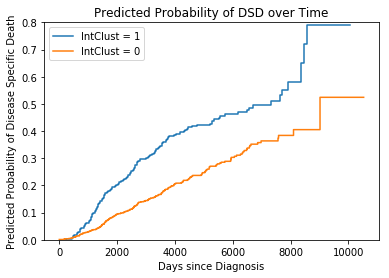

In [15]:
risk_ = [[],[]]
time_ = [[],[]]

for risk_type in (1, 0):
    mask_risk = preds_bin == risk_type
    time, survival_prob = kaplan_meier_estimator(
        Y['DeathBreast'][mask_risk],
        Y['T'][mask_risk])
    risk_[risk_type] = Y['DeathBreast'][mask_risk]
    time_[risk_type] = Y['T'][mask_risk]
    
    plt.step(time, 1 - survival_prob, where="post",
             label="IntClust = %s" % risk_type)

plt.ylabel("Predicted Probability of Disease Specific Death")
plt.xlabel("Days since Diagnosis")
plt.title("Predicted Probability of DSD over Time")
plt.ylim([0.00, 0.8])
plt.legend(loc="best")

results = logrank_test(time_[0], time_[1], risk_[0], risk_[1])
display(results.print_summary())

cph = CoxPHFitter()
Y['preds'] = preds
Y['preds_bin'] = preds_bin
cph.fit(Y[['preds_bin','Age.At.Diagnosis','Size','Lymph.Nodes.Positive','Grade','DeathBreast','T']], duration_col='T', event_col='DeathBreast', show_progress=True)
cph.print_summary()

### Local or Distant Relapse (LDR)

<lifelines.StatisticalResult>
               t_0 = -1
 null_distribution = chi squared
degrees_of_freedom = 1

---
test_statistic      p  -log2(p)
         30.58 <0.005     24.90


None

Iteration 7: norm_delta = 0.00000, step_size = 1.0000, ll = -2797.48293, newton_decrement = 0.00000, seconds_since_start = 0.2Convergence completed after 7 iterations.
<lifelines.CoxPHFitter: fitted with 1285 observations, 860 censored>
      duration col = 'TLDR'
         event col = 'LDR'
number of subjects = 1285
  number of events = 425
partial log-likelihood = -2797.48
  time fit was run = 2019-06-12 02:09:58 UTC

---
                      coef exp(coef)  se(coef)     z      p  -log2(p)  lower 0.95  upper 0.95
preds_bin             0.40      1.50      0.11  3.78 <0.005     12.63        0.19        0.61
Age.At.Diagnosis     -0.01      0.99      0.00 -1.69   0.09      3.44       -0.02        0.00
Size                  0.01      1.01      0.00  5.72 <0.005     26.45        0.01        0.02
Lymph.Nodes.Positive  0.05      1.06      0.01  6.96 <0.005     38.08        0.04        0.07
Grade                 0.11      1.12      0.08  1.38   0.17      2.58       -0.05        0.28
---
Conco

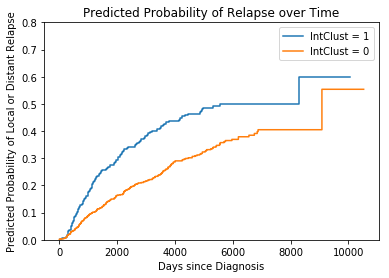

In [16]:
risk_ = [[],[]]
time_ = [[],[]]

for risk_type in (1, 0):
    mask_risk = preds_bin == risk_type
    time, survival_prob = kaplan_meier_estimator(
        Y['LDR'][mask_risk],
        Y['TLDR'][mask_risk])
    risk_[risk_type] = Y['LDR'][mask_risk]
    time_[risk_type] = Y['TLDR'][mask_risk]
    
    plt.step(time, 1 - survival_prob, where="post",
             label="IntClust = %s" % risk_type)

plt.ylabel("Predicted Probability of Local or Distant Relapse")
plt.xlabel("Days since Diagnosis")
plt.title("Predicted Probability of Relapse over Time")
plt.ylim([0.00, 0.8])
plt.legend(loc="best")

results = logrank_test(time_[0], time_[1], risk_[0], risk_[1])
display(results.print_summary())

cph = CoxPHFitter()
Y['preds'] = preds
Y['preds_bin'] = preds_bin
cph.fit(Y[['preds_bin','Age.At.Diagnosis','Size','Lymph.Nodes.Positive','Grade','LDR','TLDR']], duration_col='TLDR', event_col='LDR', show_progress=True)
cph.print_summary()

### Disease Specific Death or Distant Relapse (DDR)

<lifelines.StatisticalResult>
               t_0 = -1
 null_distribution = chi squared
degrees_of_freedom = 1

---
test_statistic      p  -log2(p)
         47.25 <0.005     37.22


None

Iteration 7: norm_delta = 0.00000, step_size = 1.0000, ll = -2765.60754, newton_decrement = 0.00000, seconds_since_start = 0.2Convergence completed after 7 iterations.
<lifelines.CoxPHFitter: fitted with 1285 observations, 859 censored>
      duration col = 'TDDR'
         event col = 'DDR'
number of subjects = 1285
  number of events = 426
partial log-likelihood = -2765.61
  time fit was run = 2019-06-12 02:09:58 UTC

---
                      coef exp(coef)  se(coef)    z      p  -log2(p)  lower 0.95  upper 0.95
preds_bin             0.47      1.60      0.11 4.43 <0.005     16.72        0.26        0.68
Age.At.Diagnosis      0.01      1.01      0.00 2.13   0.03      4.90        0.00        0.02
Size                  0.02      1.02      0.00 7.80 <0.005     47.15        0.01        0.02
Lymph.Nodes.Positive  0.06      1.06      0.01 7.72 <0.005     46.33        0.04        0.07
Grade                 0.17      1.18      0.08 1.99   0.05      4.41        0.00        0.33
---
Concordance

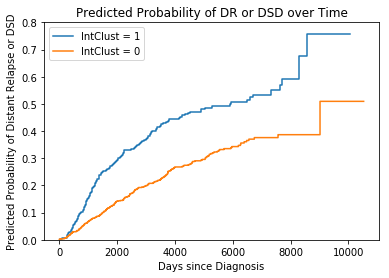

In [17]:
risk_ = [[],[]]
time_ = [[],[]]

for risk_type in (1, 0):
    mask_risk = preds_bin == risk_type
    time, survival_prob = kaplan_meier_estimator(
        Y['DDR'][mask_risk],
        Y['TDDR'][mask_risk])
    risk_[risk_type] = Y['DDR'][mask_risk]
    time_[risk_type] = Y['TDDR'][mask_risk]
    
    plt.step(time, 1 - survival_prob, where="post",
             label="IntClust = %s" % risk_type)

plt.ylabel("Predicted Probability of Distant Relapse or DSD")
plt.xlabel("Days since Diagnosis")
plt.title("Predicted Probability of DR or DSD over Time")
plt.ylim([0.00, 0.8])
plt.legend(loc="best")

results = logrank_test(time_[0], time_[1], risk_[0], risk_[1])
display(results.print_summary())

cph = CoxPHFitter()
Y['preds'] = preds
Y['preds_bin'] = preds_bin
cph.fit(Y[['preds_bin','Age.At.Diagnosis','Size','Lymph.Nodes.Positive','Grade','DDR','TDDR']], duration_col='TDDR', event_col='DDR', show_progress=True)
cph.print_summary()

### Disease Specific Death or Local Relapse (DLR)

<lifelines.StatisticalResult>
               t_0 = -1
 null_distribution = chi squared
degrees_of_freedom = 1

---
test_statistic      p  -log2(p)
         26.47 <0.005     21.83


None

Iteration 7: norm_delta = 0.00000, step_size = 1.0000, ll = -2912.90705, newton_decrement = 0.00000, seconds_since_start = 0.2Convergence completed after 7 iterations.
<lifelines.CoxPHFitter: fitted with 1285 observations, 834 censored>
      duration col = 'TDLR'
         event col = 'DLR'
number of subjects = 1285
  number of events = 451
partial log-likelihood = -2912.91
  time fit was run = 2019-06-12 02:09:58 UTC

---
                      coef exp(coef)  se(coef)    z      p  -log2(p)  lower 0.95  upper 0.95
preds_bin             0.33      1.39      0.10 3.18 <0.005      9.39        0.13        0.53
Age.At.Diagnosis      0.00      1.00      0.00 0.83   0.41      1.29       -0.00        0.01
Size                  0.01      1.01      0.00 5.49 <0.005     24.56        0.01        0.02
Lymph.Nodes.Positive  0.06      1.06      0.01 7.04 <0.005     38.88        0.04        0.07
Grade                 0.18      1.20      0.08 2.25   0.02      5.37        0.02        0.34
---
Concordance

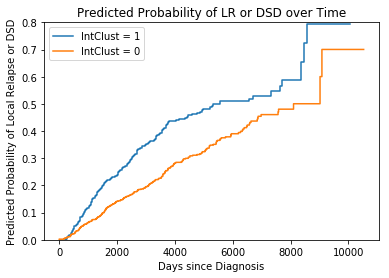

In [18]:
risk_ = [[],[]]
time_ = [[],[]]

for risk_type in (1, 0):
    mask_risk = preds_bin == risk_type
    time, survival_prob = kaplan_meier_estimator(
        Y['DLR'][mask_risk],
        Y['TDLR'][mask_risk])
    risk_[risk_type] = Y['DLR'][mask_risk]
    time_[risk_type] = Y['TDLR'][mask_risk]
    
    plt.step(time, 1 - survival_prob, where="post",
             label="IntClust = %s" % risk_type)

plt.ylabel("Predicted Probability of Local Relapse or DSD")
plt.xlabel("Days since Diagnosis")
plt.title("Predicted Probability of LR or DSD over Time")
plt.ylim([0.00, 0.8])
plt.legend(loc="best")

results = logrank_test(time_[0], time_[1], risk_[0], risk_[1])
display(results.print_summary())

cph = CoxPHFitter()
Y['preds'] = preds
Y['preds_bin'] = preds_bin
cph.fit(Y[['preds_bin','Age.At.Diagnosis','Size','Lymph.Nodes.Positive','Grade','DLR','TDLR']], duration_col='TDLR', event_col='DLR', show_progress=True)
cph.print_summary()

### Disease Specific Death or Local or Distant Relapse (DLDR)

<lifelines.StatisticalResult>
               t_0 = -1
 null_distribution = chi squared
degrees_of_freedom = 1

---
test_statistic      p  -log2(p)
         31.57 <0.005     25.63


None

Iteration 7: norm_delta = 0.00000, step_size = 1.0000, ll = -3194.91731, newton_decrement = 0.00000, seconds_since_start = 0.2Convergence completed after 7 iterations.
<lifelines.CoxPHFitter: fitted with 1285 observations, 795 censored>
      duration col = 'TDLDR'
         event col = 'DLDR'
number of subjects = 1285
  number of events = 490
partial log-likelihood = -3194.92
  time fit was run = 2019-06-12 02:09:59 UTC

---
                      coef exp(coef)  se(coef)     z      p  -log2(p)  lower 0.95  upper 0.95
preds_bin             0.36      1.43      0.10  3.62 <0.005     11.76        0.17        0.56
Age.At.Diagnosis     -0.00      1.00      0.00 -0.15   0.88      0.18       -0.01        0.01
Size                  0.02      1.02      0.00  6.21 <0.005     30.85        0.01        0.02
Lymph.Nodes.Positive  0.06      1.06      0.01  7.43 <0.005     43.09        0.04        0.07
Grade                 0.13      1.14      0.08  1.71   0.09      3.51       -0.02        0.28
---
Con

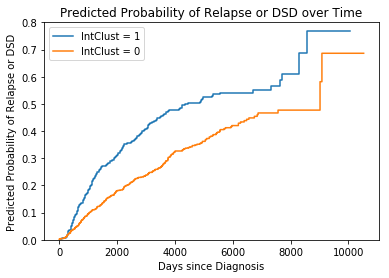

In [19]:
risk_ = [[],[]]
time_ = [[],[]]

for risk_type in (1, 0):
    mask_risk = preds_bin == risk_type
    time, survival_prob = kaplan_meier_estimator(
        Y['DLDR'][mask_risk],
        Y['TDLDR'][mask_risk])
    risk_[risk_type] = Y['DLDR'][mask_risk]
    time_[risk_type] = Y['TDLDR'][mask_risk]
    
    plt.step(time, 1 - survival_prob, where="post",
             label="IntClust = %s" % risk_type)

plt.ylabel("Predicted Probability of Relapse or DSD")
plt.xlabel("Days since Diagnosis")
plt.title("Predicted Probability of Relapse or DSD over Time")
plt.ylim([0.00, 0.8])
plt.legend(loc="best")

results = logrank_test(time_[0], time_[1], risk_[0], risk_[1])
display(results.print_summary())

cph = CoxPHFitter()
Y['preds'] = preds
Y['preds_bin'] = preds_bin
cph.fit(Y[['preds_bin','Age.At.Diagnosis','Size','Lymph.Nodes.Positive','Grade','DLDR','TDLDR']], duration_col='TDLDR', event_col='DLDR', show_progress=True)
cph.print_summary()

## Measuring C Index

In [20]:
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=0)

clinical_X = Y[['preds_bin','Age.At.Diagnosis','Size','Lymph.Nodes.Positive','Grade','DR','TDR']]

preds = np.zeros(clinical_X.shape[0])

f = 0
for train_index, test_index in cv.split(clinical_X, metabric_clinical['label']):
    X_train, X_test = clinical_X.iloc[train_index], clinical_X.iloc[test_index]
    X_test = X_test.drop('DR', axis=1)
    X_test = X_test.drop('TDR', axis=1)
    cph = CoxPHFitter()
    cph.fit(X_train, duration_col='TDR', event_col='DR')
    fold_preds = cph.predict_expectation(X_test)
    
    for i,j in zip(test_index,range(len(fold_preds))):
        preds[i] = fold_preds.iloc[j,0]
    
    f += 1
    print("Fold: \t", f)
    
c_index = concordance_index(clinical_X['TDR'], preds, clinical_X['DR'])
print(c_index)

Fold: 	 1
Fold: 	 2
Fold: 	 3
Fold: 	 4
Fold: 	 5
0.6809357311392839


## SVM with Linear Kernel

### Select C

In [50]:
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=0)
tuned_parameters = [{'C': [0.0001, 0.001, 0.01, 0.1, 1, 10]}]

best_params = []

for train_index, test_index in cv.split(X, Y['label']):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    Y_train, Y_test = Y.iloc[train_index], Y.iloc[test_index]
    scaler = StandardScaler().fit(X_train)
    X_train = scaler.transform(X_train)
    X_test = scaler.transform(X_test)
    selector = SelectKBest(f_classif, k=500).fit(X_train, Y_train['label'])
    X_train = selector.transform(X_train)
    X_test = selector.transform(X_test)
    pos = Y_train['label'] == 1
    neg = Y_train['label'] == 0
    pos_ratio = 1 / (len(Y_train['label'][pos]) / len(Y_train['label']))
    clf = GridSearchCV(SVC(kernel='linear', probability=True, class_weight={1:pos_ratio}), tuned_parameters, cv=cv, scoring='average_precision')
    clf.fit(X_train, Y_train['label'])
    print(clf.best_params_)
    best_params.append(clf.best_params_['C'])
    
best_c = Counter(best_params).most_common(1)[0][0]

print()
print("Best C: ", best_c)

{'C': 0.001}
{'C': 0.001}
{'C': 0.001}
{'C': 0.001}
{'C': 0.001}

Best C:  0.001


### AUROC

Fold: 	 1
Fold: 	 2
Fold: 	 3
Fold: 	 4
Fold: 	 5


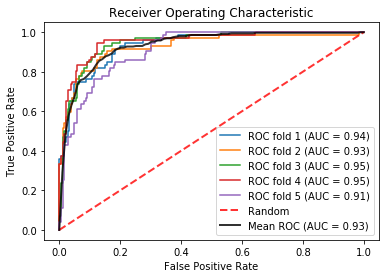

In [48]:
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=0)

tprs = []
aucs = []
mean_fpr = np.linspace(0, 1, 100)

i = 0
for train_index, test_index in cv.split(X, Y['label']):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    Y_train, Y_test = Y.iloc[train_index], Y.iloc[test_index]
    scaler = StandardScaler().fit(X_train)
    X_train = scaler.transform(X_train)
    X_test = scaler.transform(X_test)
    selector = SelectKBest(f_classif, k=500).fit(X_train, Y_train['label'])
    X_train = selector.transform(X_train)
    X_test = selector.transform(X_test)
    pos = Y_train['label'] == 1
    neg = Y_train['label'] == 0
    pos_ratio = 1 / (len(Y_train['label'][pos]) / len(Y_train['label']))
    clf = SVC(kernel='linear', C = best_c, probability=True, class_weight={1:pos_ratio})
    clf.fit(X_train, Y_train['label'])
    probas_ = clf.predict_proba(X_test)
    fpr, tpr, thresholds = roc_curve(Y_test['label'], probas_[:, 1])
    tprs.append(interp(mean_fpr, fpr, tpr))
    tprs[-1][0] = 0.0
    roc_auc = auc(fpr, tpr)
    aucs.append(roc_auc)
    plt.plot(fpr, tpr,
             label='ROC fold %d (AUC = %0.2f)' % (i+1, roc_auc))
    i += 1
    print("Fold: \t", i)
    
plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',
         label='Random', alpha=.8)

mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
std_auc = np.std(aucs)
plt.plot(mean_fpr, mean_tpr, color='black',
         label=r'Mean ROC (AUC = %0.2f)' % (mean_auc),
         lw=2, alpha=.8)

plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

### AUPRC

Fold: 	 1
Fold: 	 2
Fold: 	 3
Fold: 	 4
Fold: 	 5


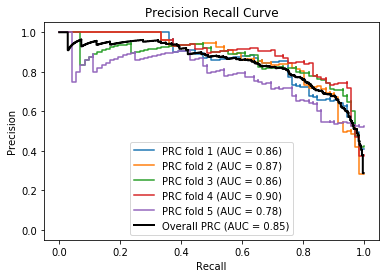

In [49]:
y_real = []
y_proba = []
auprcs = []

i = 0
for train_index, test_index in cv.split(X, Y['label']):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    Y_train, Y_test = Y.iloc[train_index], Y.iloc[test_index]
    scaler = StandardScaler().fit(X_train)
    X_train = scaler.transform(X_train)
    X_test = scaler.transform(X_test)
    selector = SelectKBest(f_classif, k=500).fit(X_train, Y_train['label'])
    X_train = selector.transform(X_train)
    X_test = selector.transform(X_test)
    pos = Y_train['label'] == 1
    neg = Y_train['label'] == 0
    pos_ratio = 1 / (len(Y_train['label'][pos]) / len(Y_train['label']))
    clf = SVC(kernel='linear', C = best_c, probability=True, class_weight={1:pos_ratio})
    clf.fit(X_train, Y_train['label'])
    probas_ = clf.predict_proba(X_test)
    precision, recall, _ = precision_recall_curve(Y_test['label'], probas_[:,1])
    auprc = auc(recall, precision)
    lab = 'PRC fold %d (AUC = %0.2f)' % (i+1, auprc)
    plt.step(recall, precision, label=lab)
    y_real.append(Y_test['label'])
    y_proba.append(probas_[:,1])
    auprcs.append(auprc)
    i += 1
    print("Fold: \t", i)
    
y_real = np.concatenate(y_real)
y_proba = np.concatenate(y_proba)
precision, recall, _ = precision_recall_curve(y_real, y_proba)
lab = 'Overall PRC (AUC = %0.2f)' % (auc(recall, precision))
plt.step(recall, precision, label=lab, lw=2, color='black')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend(loc='lower center')
plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.title('Precision Recall Curve')
plt.show()

### Predict

In [47]:
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=0)

preds = np.zeros(Y['label'].shape[0])
preds_bin = np.zeros(Y['label'].shape[0])

auroc = []
auprc = []
nll = []
f1 = []
precision = []
recall = []

f = 0
for train_index, test_index in cv.split(X, Y['label']):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    Y_train, Y_test = Y.iloc[train_index], Y.iloc[test_index]
    scaler = StandardScaler().fit(X_train)
    X_train = scaler.transform(X_train)
    X_test = scaler.transform(X_test)
    selector = SelectKBest(f_classif, k=500).fit(X_train, Y_train['label'])
    X_train = selector.transform(X_train)
    X_test = selector.transform(X_test)
    pos = Y_train['label'] == 1
    neg = Y_train['label'] == 0
    pos_ratio = 1 / (len(Y_train['label'][pos]) / len(Y_train['label']))
    clf = SVC(kernel='linear', C = best_c, probability=True, class_weight={1:pos_ratio})
    clf.fit(X_train, Y_train['label'])
    fold_preds = clf.predict_proba(X_test)[:,1]

    auroc.append(roc_auc_score(Y_test['label'], fold_preds))
    auprc.append(average_precision_score(Y_test['label'], fold_preds))
    nll.append(log_loss(Y_test['label'], fold_preds))
    
    fold_preds_bin = clf.predict(X_test)
    
    f1.append(f1_score(Y_test['label'], fold_preds_bin))
    precision.append(precision_score(Y_test['label'], fold_preds_bin))
    recall.append(recall_score(Y_test['label'], fold_preds_bin))
    
    for i,j in zip(test_index,range(len(fold_preds))):
        preds[i] = fold_preds[j]
        preds_bin[i] = fold_preds_bin[j]

    f += 1
    print("Fold: \t", f)

print()
#print('AUROC: \t\t', round(mean(auroc),4))
#print('AUPRC: \t\t', round(mean(auprc),4))
#print('NLL: \t\t', round(mean(nll), 4))
print('F1: \t\t', round(mean(f1), 4))
print('Precision: \t', round(mean(precision), 4))
print('Recall: \t', round(mean(recall), 4))

Fold: 	 1
Fold: 	 2
Fold: 	 3
Fold: 	 4
Fold: 	 5

AUROC: 		 0.9355
AUPRC: 		 0.8558
NLL: 		 0.2949
F1: 		 0.777
Precision: 	 0.7056
Recall: 	 0.8667


## Evaluate

### Normalized Confusion Matrix

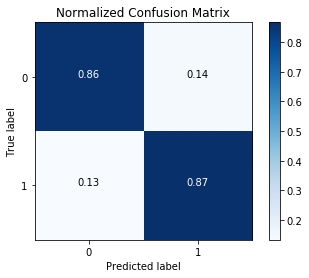

In [25]:
import itertools

cm = confusion_matrix(Y['label'],preds_bin)
cm = cm.astype('float') / cm.sum(axis = 1)[:, np.newaxis]

plt.imshow(cm, cmap=plt.cm.Blues)
plt.title('Normalized Confusion Matrix')
plt.colorbar()
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.xticks([0, 1]); plt.yticks([0, 1])
plt.grid(False)
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, format(cm[i, j], '.2f'),
             horizontalalignment='center',
             color='white' if cm[i, j] > 0.5 else 'black')

### Raw Confusion Matrix

Confusion matrix:
 [[793 132]
 [ 48 312]]


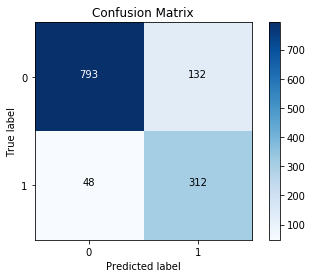

In [26]:
cm = confusion_matrix(Y['label'],preds_bin)
print('Confusion matrix:\n',cm)

plt.imshow(cm, cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.xticks([0, 1]); plt.yticks([0, 1])
plt.grid(False)
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, format(cm[i, j]),
             horizontalalignment='center',
             color='white' if cm[i, j] > 500 else 'black')

## Survival Analysis on Predictions

### Distant Relapse (DR)

<lifelines.StatisticalResult>
               t_0 = -1
 null_distribution = chi squared
degrees_of_freedom = 1

---
test_statistic      p  -log2(p)
         46.18 <0.005     36.43


None

Iteration 7: norm_delta = 0.00000, step_size = 1.0000, ll = -2324.52416, newton_decrement = 0.00000, seconds_since_start = 0.2Convergence completed after 7 iterations.
<lifelines.CoxPHFitter: fitted with 1285 observations, 931 censored>
      duration col = 'TDR'
         event col = 'DR'
number of subjects = 1285
  number of events = 354
partial log-likelihood = -2324.52
  time fit was run = 2019-06-12 02:12:42 UTC

---
                      coef exp(coef)  se(coef)    z      p  -log2(p)  lower 0.95  upper 0.95
preds_bin             0.54      1.72      0.11 4.71 <0.005     18.61        0.32        0.77
Age.At.Diagnosis      0.00      1.00      0.00 0.35   0.72      0.46       -0.01        0.01
Size                  0.02      1.02      0.00 7.19 <0.005     40.48        0.01        0.02
Lymph.Nodes.Positive  0.06      1.06      0.01 7.11 <0.005     39.64        0.04        0.07
Grade                 0.15      1.16      0.09 1.65   0.10      3.33       -0.03        0.33
---
Concordance =

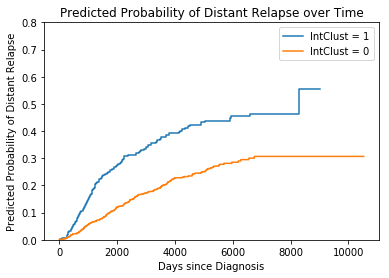

In [27]:
risk_ = [[],[]]
time_ = [[],[]]

for risk_type in (1, 0):
    mask_risk = preds_bin == risk_type
    time, survival_prob = kaplan_meier_estimator(
        Y['DR'][mask_risk],
        Y['TDR'][mask_risk])
    risk_[risk_type] = Y['DR'][mask_risk]
    time_[risk_type] = Y['TDR'][mask_risk]
    
    plt.step(time, 1 - survival_prob, where="post",
             label="IntClust = %s" % risk_type)

plt.ylabel("Predicted Probability of Distant Relapse")
plt.xlabel("Days since Diagnosis")
plt.title("Predicted Probability of Distant Relapse over Time")
plt.ylim([0.00, 0.8])
plt.legend(loc="best")

results = logrank_test(time_[0], time_[1], risk_[0], risk_[1])
display(results.print_summary())

cph = CoxPHFitter()
Y['preds'] = preds
Y['preds_bin'] = preds_bin
cph.fit(Y[['preds_bin','Age.At.Diagnosis','Size','Lymph.Nodes.Positive','Grade','DR','TDR']], duration_col='TDR', event_col='DR', show_progress=True)
cph.print_summary()

### Local Relapse (LR)

<lifelines.StatisticalResult>
               t_0 = -1
 null_distribution = chi squared
degrees_of_freedom = 1

---
test_statistic    p  -log2(p)
          1.71 0.19      2.39


None

Iteration 7: norm_delta = 0.00000, step_size = 1.0000, ll = -1121.80647, newton_decrement = 0.00000, seconds_since_start = 0.1Convergence completed after 7 iterations.
<lifelines.CoxPHFitter: fitted with 1285 observations, 1115 censored>
      duration col = 'TLR'
         event col = 'LR'
number of subjects = 1285
  number of events = 170
partial log-likelihood = -1121.81
  time fit was run = 2019-06-12 02:12:42 UTC

---
                      coef exp(coef)  se(coef)     z      p  -log2(p)  lower 0.95  upper 0.95
preds_bin             0.09      1.09      0.17  0.50   0.61      0.70       -0.25        0.42
Age.At.Diagnosis     -0.03      0.97      0.01 -3.94 <0.005     13.61       -0.04       -0.01
Size                  0.01      1.01      0.00  1.27   0.20      2.30       -0.00        0.02
Lymph.Nodes.Positive  0.06      1.06      0.01  4.26 <0.005     15.55        0.03        0.08
Grade                 0.19      1.21      0.13  1.49   0.14      2.87       -0.06        0.45
---
Concor

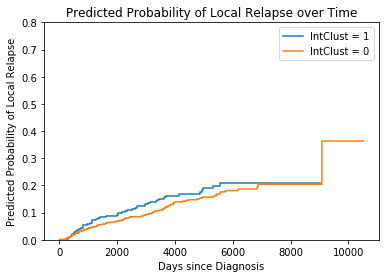

In [28]:
risk_ = [[],[]]
time_ = [[],[]]

for risk_type in (1, 0):
    mask_risk = preds_bin == risk_type
    time, survival_prob = kaplan_meier_estimator(
        Y['LR'][mask_risk],
        Y['TLR'][mask_risk])
    risk_[risk_type] = Y['LR'][mask_risk]
    time_[risk_type] = Y['TLR'][mask_risk]
    
    plt.step(time, 1 - survival_prob, where="post",
             label="IntClust = %s" % risk_type)

plt.ylabel("Predicted Probability of Local Relapse")
plt.xlabel("Days since Diagnosis")
plt.title("Predicted Probability of Local Relapse over Time")
plt.ylim([0.00, 0.8])
plt.legend(loc="best")

results = logrank_test(time_[0], time_[1], risk_[0], risk_[1])
display(results.print_summary())

cph = CoxPHFitter()
Y['preds'] = preds
Y['preds_bin'] = preds_bin
cph.fit(Y[['preds_bin','Age.At.Diagnosis','Size','Lymph.Nodes.Positive','Grade','LR','TLR']], duration_col='TLR', event_col='LR', show_progress=True)
cph.print_summary()

### Disease Specific Death (DSD)

<lifelines.StatisticalResult>
               t_0 = -1
 null_distribution = chi squared
degrees_of_freedom = 1

---
test_statistic      p  -log2(p)
         39.44 <0.005     31.46


None

Iteration 7: norm_delta = 0.00000, step_size = 1.0000, ll = -2378.47400, newton_decrement = 0.00000, seconds_since_start = 0.2Convergence completed after 7 iterations.
<lifelines.CoxPHFitter: fitted with 1285 observations, 912 censored>
      duration col = 'T'
         event col = 'DeathBreast'
number of subjects = 1285
  number of events = 373
partial log-likelihood = -2378.47
  time fit was run = 2019-06-12 02:12:42 UTC

---
                      coef exp(coef)  se(coef)    z      p  -log2(p)  lower 0.95  upper 0.95
preds_bin             0.43      1.54      0.11 3.87 <0.005     13.15        0.21        0.65
Age.At.Diagnosis      0.02      1.02      0.00 3.80 <0.005     12.73        0.01        0.03
Size                  0.02      1.02      0.00 6.99 <0.005     38.38        0.01        0.02
Lymph.Nodes.Positive  0.05      1.06      0.01 6.93 <0.005     37.76        0.04        0.07
Grade                 0.27      1.31      0.09 2.97 <0.005      8.39        0.09        0.45
---
Concor

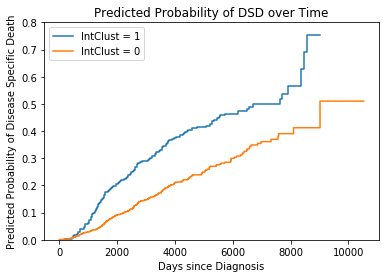

In [29]:
risk_ = [[],[]]
time_ = [[],[]]

for risk_type in (1, 0):
    mask_risk = preds_bin == risk_type
    time, survival_prob = kaplan_meier_estimator(
        Y['DeathBreast'][mask_risk],
        Y['T'][mask_risk])
    risk_[risk_type] = Y['DeathBreast'][mask_risk]
    time_[risk_type] = Y['T'][mask_risk]
    
    plt.step(time, 1 - survival_prob, where="post",
             label="IntClust = %s" % risk_type)

plt.ylabel("Predicted Probability of Disease Specific Death")
plt.xlabel("Days since Diagnosis")
plt.title("Predicted Probability of DSD over Time")
plt.ylim([0.00, 0.8])
plt.legend(loc="best")

results = logrank_test(time_[0], time_[1], risk_[0], risk_[1])
display(results.print_summary())

cph = CoxPHFitter()
Y['preds'] = preds
Y['preds_bin'] = preds_bin
cph.fit(Y[['preds_bin','Age.At.Diagnosis','Size','Lymph.Nodes.Positive','Grade','DeathBreast','T']], duration_col='T', event_col='DeathBreast', show_progress=True)
cph.print_summary()

### Local or Distant Relapse (LDR)

<lifelines.StatisticalResult>
               t_0 = -1
 null_distribution = chi squared
degrees_of_freedom = 1

---
test_statistic      p  -log2(p)
         29.42 <0.005     24.04


None

Iteration 7: norm_delta = 0.00000, step_size = 1.0000, ll = -2797.70230, newton_decrement = 0.00000, seconds_since_start = 0.2Convergence completed after 7 iterations.
<lifelines.CoxPHFitter: fitted with 1285 observations, 860 censored>
      duration col = 'TLDR'
         event col = 'LDR'
number of subjects = 1285
  number of events = 425
partial log-likelihood = -2797.70
  time fit was run = 2019-06-12 02:12:43 UTC

---
                      coef exp(coef)  se(coef)     z      p  -log2(p)  lower 0.95  upper 0.95
preds_bin             0.39      1.48      0.11  3.72 <0.005     12.28        0.19        0.60
Age.At.Diagnosis     -0.01      0.99      0.00 -1.68   0.09      3.44       -0.02        0.00
Size                  0.01      1.01      0.00  5.72 <0.005     26.45        0.01        0.02
Lymph.Nodes.Positive  0.05      1.06      0.01  6.93 <0.005     37.78        0.04        0.07
Grade                 0.12      1.13      0.08  1.51   0.13      2.93       -0.04        0.29
---
Conco

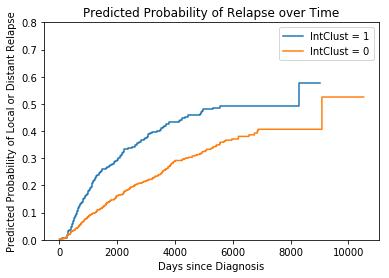

In [30]:
risk_ = [[],[]]
time_ = [[],[]]

for risk_type in (1, 0):
    mask_risk = preds_bin == risk_type
    time, survival_prob = kaplan_meier_estimator(
        Y['LDR'][mask_risk],
        Y['TLDR'][mask_risk])
    risk_[risk_type] = Y['LDR'][mask_risk]
    time_[risk_type] = Y['TLDR'][mask_risk]
    
    plt.step(time, 1 - survival_prob, where="post",
             label="IntClust = %s" % risk_type)

plt.ylabel("Predicted Probability of Local or Distant Relapse")
plt.xlabel("Days since Diagnosis")
plt.title("Predicted Probability of Relapse over Time")
plt.ylim([0.00, 0.8])
plt.legend(loc="best")

results = logrank_test(time_[0], time_[1], risk_[0], risk_[1])
display(results.print_summary())

cph = CoxPHFitter()
Y['preds'] = preds
Y['preds_bin'] = preds_bin
cph.fit(Y[['preds_bin','Age.At.Diagnosis','Size','Lymph.Nodes.Positive','Grade','LDR','TLDR']], duration_col='TLDR', event_col='LDR', show_progress=True)
cph.print_summary()

### Disease Specific Death or Distant Relapse (DDR)

<lifelines.StatisticalResult>
               t_0 = -1
 null_distribution = chi squared
degrees_of_freedom = 1

---
test_statistic      p  -log2(p)
         45.74 <0.005     36.10


None

Iteration 7: norm_delta = 0.00000, step_size = 1.0000, ll = -2765.84519, newton_decrement = 0.00000, seconds_since_start = 0.2Convergence completed after 7 iterations.
<lifelines.CoxPHFitter: fitted with 1285 observations, 859 censored>
      duration col = 'TDDR'
         event col = 'DDR'
number of subjects = 1285
  number of events = 426
partial log-likelihood = -2765.85
  time fit was run = 2019-06-12 02:12:43 UTC

---
                      coef exp(coef)  se(coef)    z      p  -log2(p)  lower 0.95  upper 0.95
preds_bin             0.46      1.58      0.10 4.38 <0.005     16.36        0.25        0.66
Age.At.Diagnosis      0.01      1.01      0.00 2.12   0.03      4.89        0.00        0.02
Size                  0.02      1.02      0.00 7.80 <0.005     47.23        0.01        0.02
Lymph.Nodes.Positive  0.06      1.06      0.01 7.68 <0.005     45.83        0.04        0.07
Grade                 0.18      1.19      0.08 2.13   0.03      4.92        0.01        0.34
---
Concordance

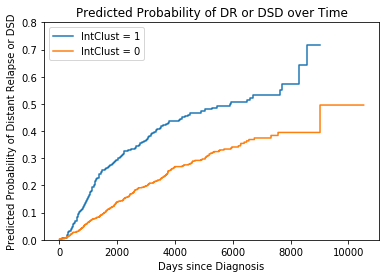

In [31]:
risk_ = [[],[]]
time_ = [[],[]]

for risk_type in (1, 0):
    mask_risk = preds_bin == risk_type
    time, survival_prob = kaplan_meier_estimator(
        Y['DDR'][mask_risk],
        Y['TDDR'][mask_risk])
    risk_[risk_type] = Y['DDR'][mask_risk]
    time_[risk_type] = Y['TDDR'][mask_risk]
    
    plt.step(time, 1 - survival_prob, where="post",
             label="IntClust = %s" % risk_type)

plt.ylabel("Predicted Probability of Distant Relapse or DSD")
plt.xlabel("Days since Diagnosis")
plt.title("Predicted Probability of DR or DSD over Time")
plt.ylim([0.00, 0.8])
plt.legend(loc="best")

results = logrank_test(time_[0], time_[1], risk_[0], risk_[1])
display(results.print_summary())

cph = CoxPHFitter()
Y['preds'] = preds
Y['preds_bin'] = preds_bin
cph.fit(Y[['preds_bin','Age.At.Diagnosis','Size','Lymph.Nodes.Positive','Grade','DDR','TDDR']], duration_col='TDDR', event_col='DDR', show_progress=True)
cph.print_summary()

### Disease Specific Death or Local Relapse (DLR)

<lifelines.StatisticalResult>
               t_0 = -1
 null_distribution = chi squared
degrees_of_freedom = 1

---
test_statistic      p  -log2(p)
         23.40 <0.005     19.54


None

Iteration 7: norm_delta = 0.00000, step_size = 1.0000, ll = -2913.70768, newton_decrement = 0.00000, seconds_since_start = 0.2Convergence completed after 7 iterations.
<lifelines.CoxPHFitter: fitted with 1285 observations, 834 censored>
      duration col = 'TDLR'
         event col = 'DLR'
number of subjects = 1285
  number of events = 451
partial log-likelihood = -2913.71
  time fit was run = 2019-06-12 02:12:44 UTC

---
                      coef exp(coef)  se(coef)    z      p  -log2(p)  lower 0.95  upper 0.95
preds_bin             0.30      1.35      0.10 2.91 <0.005      8.11        0.10        0.50
Age.At.Diagnosis      0.00      1.00      0.00 0.84   0.40      1.31       -0.00        0.01
Size                  0.01      1.01      0.00 5.48 <0.005     24.52        0.01        0.02
Lymph.Nodes.Positive  0.06      1.06      0.01 7.01 <0.005     38.58        0.04        0.07
Grade                 0.20      1.22      0.08 2.44   0.01      6.09        0.04        0.35
---
Concordance

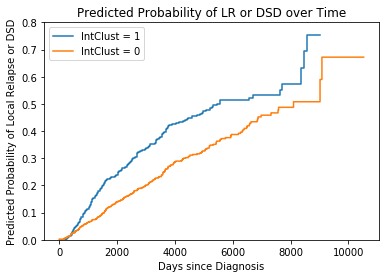

In [32]:
risk_ = [[],[]]
time_ = [[],[]]

for risk_type in (1, 0):
    mask_risk = preds_bin == risk_type
    time, survival_prob = kaplan_meier_estimator(
        Y['DLR'][mask_risk],
        Y['TDLR'][mask_risk])
    risk_[risk_type] = Y['DLR'][mask_risk]
    time_[risk_type] = Y['TDLR'][mask_risk]
    
    plt.step(time, 1 - survival_prob, where="post",
             label="IntClust = %s" % risk_type)

plt.ylabel("Predicted Probability of Local Relapse or DSD")
plt.xlabel("Days since Diagnosis")
plt.title("Predicted Probability of LR or DSD over Time")
plt.ylim([0.00, 0.8])
plt.legend(loc="best")

results = logrank_test(time_[0], time_[1], risk_[0], risk_[1])
display(results.print_summary())

cph = CoxPHFitter()
Y['preds'] = preds
Y['preds_bin'] = preds_bin
cph.fit(Y[['preds_bin','Age.At.Diagnosis','Size','Lymph.Nodes.Positive','Grade','DLR','TDLR']], duration_col='TDLR', event_col='DLR', show_progress=True)
cph.print_summary()

### Disease Specific Death or Local or Distant Relapse (DLDR)

<lifelines.StatisticalResult>
               t_0 = -1
 null_distribution = chi squared
degrees_of_freedom = 1

---
test_statistic      p  -log2(p)
         30.02 <0.005     24.48


None

Iteration 7: norm_delta = 0.00000, step_size = 1.0000, ll = -3195.23229, newton_decrement = 0.00000, seconds_since_start = 0.2Convergence completed after 7 iterations.
<lifelines.CoxPHFitter: fitted with 1285 observations, 795 censored>
      duration col = 'TDLDR'
         event col = 'DLDR'
number of subjects = 1285
  number of events = 490
partial log-likelihood = -3195.23
  time fit was run = 2019-06-12 02:12:44 UTC

---
                      coef exp(coef)  se(coef)     z      p  -log2(p)  lower 0.95  upper 0.95
preds_bin             0.35      1.42      0.10  3.54 <0.005     11.26        0.16        0.54
Age.At.Diagnosis     -0.00      1.00      0.00 -0.14   0.89      0.17       -0.01        0.01
Size                  0.02      1.02      0.00  6.22 <0.005     30.88        0.01        0.02
Lymph.Nodes.Positive  0.05      1.06      0.01  7.40 <0.005     42.72        0.04        0.07
Grade                 0.14      1.15      0.08  1.85   0.06      3.96       -0.01        0.29
---
Con

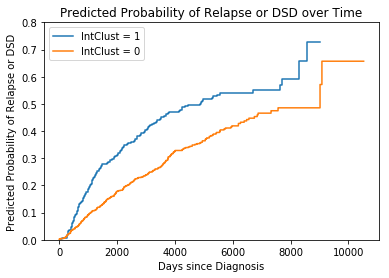

In [33]:
risk_ = [[],[]]
time_ = [[],[]]

for risk_type in (1, 0):
    mask_risk = preds_bin == risk_type
    time, survival_prob = kaplan_meier_estimator(
        Y['DLDR'][mask_risk],
        Y['TDLDR'][mask_risk])
    risk_[risk_type] = Y['DLDR'][mask_risk]
    time_[risk_type] = Y['TDLDR'][mask_risk]
    
    plt.step(time, 1 - survival_prob, where="post",
             label="IntClust = %s" % risk_type)

plt.ylabel("Predicted Probability of Relapse or DSD")
plt.xlabel("Days since Diagnosis")
plt.title("Predicted Probability of Relapse or DSD over Time")
plt.ylim([0.00, 0.8])
plt.legend(loc="best")

results = logrank_test(time_[0], time_[1], risk_[0], risk_[1])
display(results.print_summary())

cph = CoxPHFitter()
Y['preds'] = preds
Y['preds_bin'] = preds_bin
cph.fit(Y[['preds_bin','Age.At.Diagnosis','Size','Lymph.Nodes.Positive','Grade','DLDR','TDLDR']], duration_col='TDLDR', event_col='DLDR', show_progress=True)
cph.print_summary()

## Measuring C Index

In [34]:
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=0)

clinical_X = Y[['preds_bin','Age.At.Diagnosis','Size','Lymph.Nodes.Positive','Grade','DR','TDR']]

preds = np.zeros(clinical_X.shape[0])

f = 0
for train_index, test_index in cv.split(clinical_X, metabric_clinical['label']):
    X_train, X_test = clinical_X.iloc[train_index], clinical_X.iloc[test_index]
    X_test = X_test.drop('DR', axis=1)
    X_test = X_test.drop('TDR', axis=1)
    cph = CoxPHFitter()
    cph.fit(X_train, duration_col='TDR', event_col='DR')
    fold_preds = cph.predict_expectation(X_test)
    
    for i,j in zip(test_index,range(len(fold_preds))):
        preds[i] = fold_preds.iloc[j,0]
    
    f += 1
    print("Fold: \t", f)
    
c_index = concordance_index(clinical_X['TDR'], preds, clinical_X['DR'])
print(c_index)

Fold: 	 1
Fold: 	 2
Fold: 	 3
Fold: 	 4
Fold: 	 5
0.6811343936819199
